In [140]:
import numpy as np
import matplotlib.pyplot as plt
import random

import Models.OWID as owid
import Models.SIRD as sird
import Models.GradientDescent as gd

import scipy.optimize as opt

#parameters are [A(0), I(0), gamma0, gamma1, nu, beta0, beta1, beta2, u(t) vars]
#consts are [dayNum, I[0], maxI, len(u(t))]

#A' = (b0 / (1 + (b1 * I)**(b2 * u(t)) ) )*A - gamma0*A
#I' = gamma1*A - nu*I


def startFunc(consts):
    
    #return ukVars
    params = np.zeros(8)
        
    params[0] = .0005 + consts[1] #A(0), between 0 and 10 percent of the population
    params[1] = consts[1] #10e-10 + random.random()*.01 #I(0), between 0 and .1 percent of the population, avoid 0
    
    params[2] = .1 + random.random()*.4 #gamma0, asympt->recovs + infected - floor asympt infect rate
    params[3] = .001 + random.random()*.1 #gamma1, asympt->infected
    
    params[4] = .001 + random.random()*.1 #nu, infected -> recov or dead

    params[5] = .3 + random.random()*1.5 #beta0, ceiling infectRate - floor infect rate
    params[6] = 25 + 250*random.random() #beta2, scaler on feedback
    params[7] = .5 + random.random()*2 #beta3, exponential [.5, 5.5]
    
    #beta1 = (b0/gamma0 - 1)**(1/u(t)*b2) / maxI
    #params[6] = ((params[5]/params[2])-1)**(1/(params[7])) / consts[2]
    
    
    return params
    
def simFunc(params, consts, giveA=False): #option to return A and I

    dayNum = consts[0]
    
    A = np.zeros((dayNum))
    I = np.zeros((dayNum))
    
    A[0] = params[0]
    I[0] = params[1]
    
    gamma0 = params[2]
    gamma1 = params[3]
    nu = params[4]
    
    beta = params[5:8]

    #print(params)
    
    #iterate the arrays using the definition K' and I'
    for t in range(len(I)-1): #define I and K on range [1, length)
        diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]
        diffI = gamma1*A[t] - nu*I[t]
        
        A[t+1] = diffA + A[t]
        I[t+1] = diffI + I[t]

    if(giveA):
        return A,I
        
    return I #I is the data generated

def constrainFunc(parameters, consts):
    
    params = np.copy(parameters)

    #fill the constraints
    paramConstraints = np.zeros((len(params),2)) #min, max for each one
    
    paramConstraints[0] = [.0000000001, .5] #A(0)
    paramConstraints[1] = [ 0.000000001, .25] #I(0)

    paramConstraints[2] = [0.00001, parameters[5]] #gamma0, has to be less than ceiling infection rate
    paramConstraints[3] = [0.00001, .9] #gamma1
    
    paramConstraints[4] = [0.00001, .9] #nu

    paramConstraints[5] = [.1, 100] #beta0, beta ceiling
    paramConstraints[6] = [.1, 100000] #beta1, feedback scaling
    paramConstraints[7] = [.25, 10] #beta2
    
    for i in range(len(params)): #exercise each constraint
        params[i] = min( max(paramConstraints[i,0], params[i]) , paramConstraints[i,1])
    
    return params

def graphParams(params, consts, graphA=False):
    A, I = simFunc(params, consts, giveA=True)
    
    fig, ax = plt.subplots(figsize=(18,8))
    if(graphA):
        ax.plot(A, color="orange", linestyle="dashed", alpha=.7)
    ax.plot(I, color="red")
    return fig, ax




#x is the starting params, args = (consts, y)
def errFunc(x, consts, normalWeight, slopeWeight, wDecay, skip, y):
    
    def simFunction(params, consts, giveA=False): #option to return A and I

        dayNum = consts[0]

        A = np.zeros((dayNum))
        I = np.zeros((dayNum))

        A[0] = params[0]
        I[0] = params[1]

        gamma0 = params[2]
        gamma1 = params[3]
        nu = params[4]

        beta = params[5:8]

        #print(params)

        #iterate the arrays using the definition K' and I'
        for t in range(len(I)-1): #define I and K on range [1, length)
            diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]
            diffI = gamma1*A[t] - nu*I[t]

            A[t+1] = diffA + A[t]
            I[t+1] = diffI + I[t]

        if(giveA):
            return A,I

        return I #I is the data generated

    x = simFunction(x, consts)
    
    error = 0
    if(normalWeight!=0):
        for t in range(skip,len(y)):
            error = error + ((y[t] - x[t])**2)*wDecay**(len(y)-t+1) #squared error
        error = error / len(y) # / T, average error
    
    
    slopeError = 0
    if(slopeWeight!=0):
        dy = np.diff(y)
        dx = np.diff(x)
        for t in range(skip,len(dy)):
            slopeError = slopeError +  ((dy[t] - dx[t])**2)*wDecay**(len(dy)-t+1) #squared error
        slopeError = slopeError / len(dy) # / T, average error

    return error*normalWeight + slopeError*slopeWeight



def getParams(I, consts, normalWeight=1, slopeWeight=0, wDecay=1, skip=0, randomIterCount=100, method="SLSQP"):
    bestParams = startFunc(consts)
    bestError = 10e10 #arbitrary large value
    
    for i in range(randomIterCount):
        
        newParams = startFunc(consts)
        newParams = opt.minimize(errFunc, newParams, (consts, normalWeight, slopeWeight, wDecay, skip, I), method=method)['x']
        newError = errFunc(newParams, consts, normalWeight, slopeWeight, wDecay, skip, I)
    
        if(newError < bestError):
            bestError = newError
            bestParams = newParams
            print(i, "New best error: ", bestError)
            
    return bestParams

def getStablePoint(params, consts):
    #I stable point = (b0/gamm0 - 1)^(1/b2) / b1
    #A stable point = nu/gamma1 * (b0/gamm0 - 1)^(1/b2) / b1
    
    gamma0 = params[2]
    gamma1 = params[3]
    nu = params[4]
    beta = params[5:]
    
    return (beta[0]/gamma0 - 1)**(1/beta[2]) / beta[1]

In [2]:
randomIterCount = 100
quickRunIters = 25 #how many interations on the first convergance
lastRunIters = 500
beginEta = .01 #large learnin rate for quick converging
finalEta = .01

slopeWeight = 1

## Italy

<ipython-input-110-970be1962c01>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  1.2964136246744553e-05
1 New best error:  1.0181647747143805e-05
6 New best error:  9.962652786601108e-06
16 New best error:  9.935186532153712e-06
83 New best error:  8.656886989639101e-06
143 New best error:  8.612721153296039e-06
322 New best error:  8.413495031542356e-06


(0.0, 0.023256980589902283)

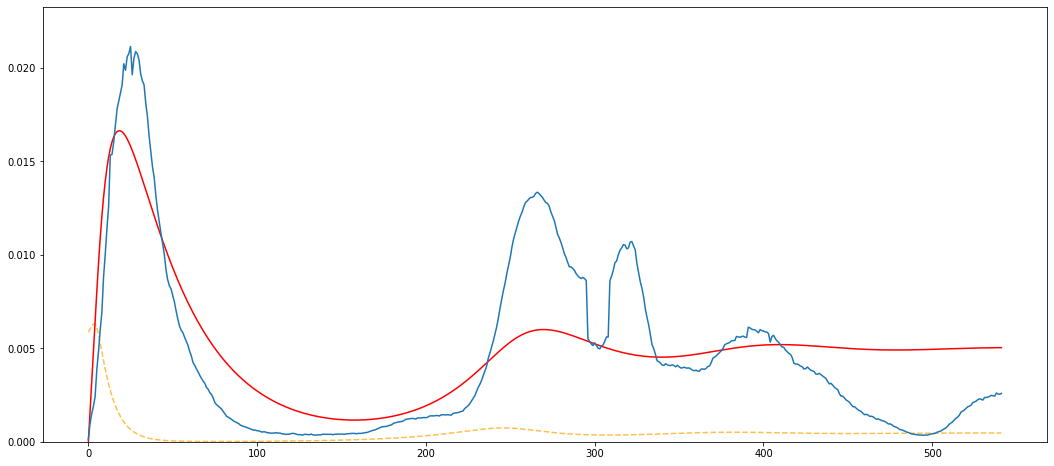

In [133]:
dates, I, R, D, V = owid.LoadCountryNormal("Italy")
consts = [len(I), I[0], max(I), 0]

italyParams = getParams(I, consts, randomIterCount=500, method = "Nelder-Mead")

fig,ax = graphParams(italyParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## US

0 New best error:  7.730164756710843e-06


<ipython-input-87-da76d6452b2c>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


2 New best error:  7.523682794230753e-06
3 New best error:  7.119367232668655e-06
29 New best error:  6.921993657102035e-06


<ipython-input-87-da76d6452b2c>:131: RuntimeWarning: overflow encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


(0.0, 0.02025101885499741)

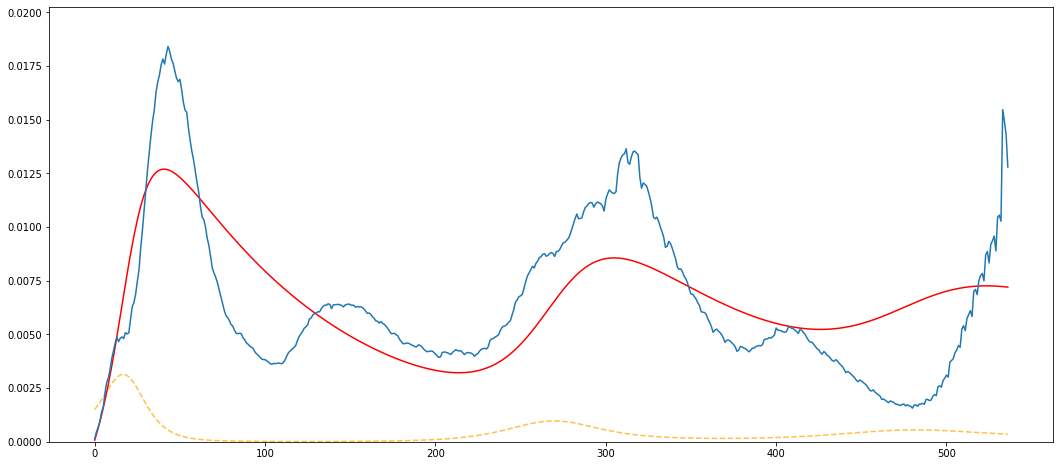

In [93]:
dates, I, R, D, V = owid.LoadCountryNormal("United States")
consts = [len(I), I[0], max(I), 0]

usParams = getParams(I, consts, randomIterCount=500, method = "Nelder-Mead")

fig,ax = graphParams(usParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## UK

<ipython-input-110-970be1962c01>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  4.2262691872083574e-05
3 New best error:  4.187078346547671e-05


<ipython-input-110-970be1962c01>:131: RuntimeWarning: overflow encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]
<ipython-input-110-970be1962c01>:147: RuntimeWarning: overflow encountered in double_scalars
  error = error + ((y[t] - x[t])**2)*wDecay**(len(y)-t+1) #squared error


363 New best error:  4.1690381671776184e-05


(0.0, 0.08622537289890751)

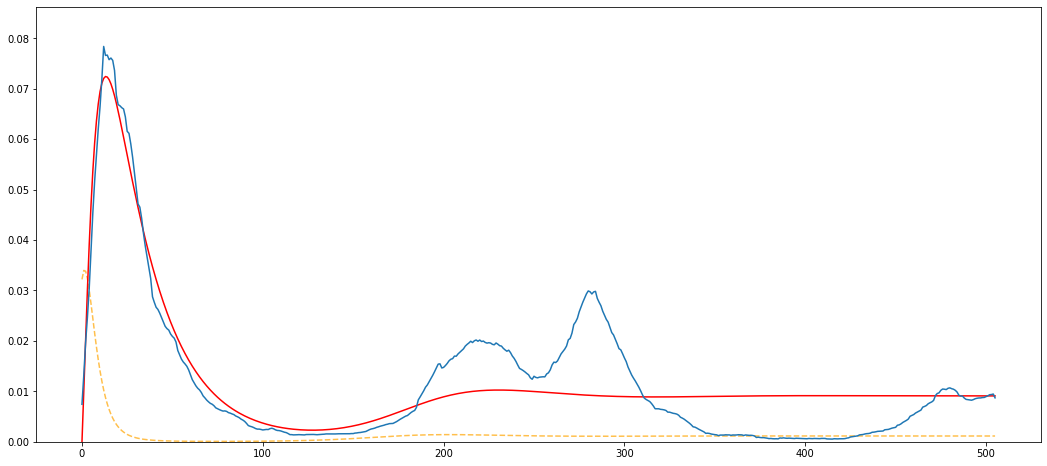

In [132]:
dates, I, R, D, V = owid.LoadCountryNormal("United Kingdom")
consts = [len(I), I[0], max(I), 0]

ukParams = getParams(I, consts, randomIterCount=500, method = "Nelder-Mead")

fig,ax = graphParams(ukParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Canada

0 New best error:  1.505957677784158e-06
1 New best error:  1.095530773799825e-06


<ipython-input-87-da76d6452b2c>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


2 New best error:  1.0137753869474373e-06
5 New best error:  9.040988343503356e-07
11 New best error:  9.026479194811105e-07
20 New best error:  8.781909367582911e-07
34 New best error:  8.702894680553935e-07
346 New best error:  8.63798441686752e-07


(0.0, 0.00825423416306772)

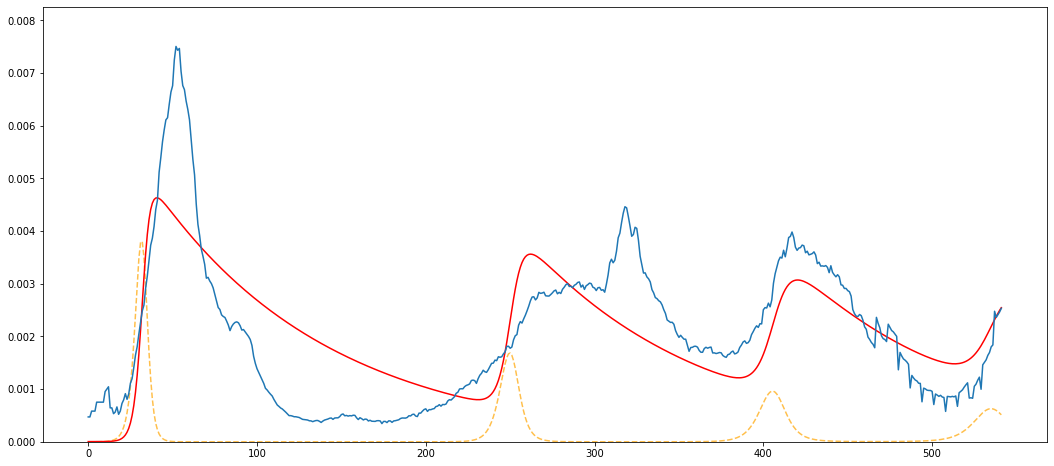

In [95]:
dates, I, R, D, V = owid.LoadCountryNormal("Canada")
consts = [len(I), I[0], max(I), 0]

canadaParams = getParams(I, consts, randomIterCount=500, method = "Nelder-Mead")

fig,ax = graphParams(canadaParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Mexico

0 New best error:  3.516047886301244e-07


<ipython-input-87-da76d6452b2c>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


1 New best error:  2.6795756163107196e-07
2 New best error:  1.6701766033321808e-07
3 New best error:  1.4978138840454012e-07
4 New best error:  1.4845865562122433e-07
7 New best error:  1.4784801744506515e-07
29 New best error:  1.4780880641037913e-07
38 New best error:  1.476870098299462e-07
47 New best error:  1.4573508857695702e-07
136 New best error:  1.4383098281818205e-07
466 New best error:  1.4077304886673565e-07


(0.0, 0.003891339995192922)

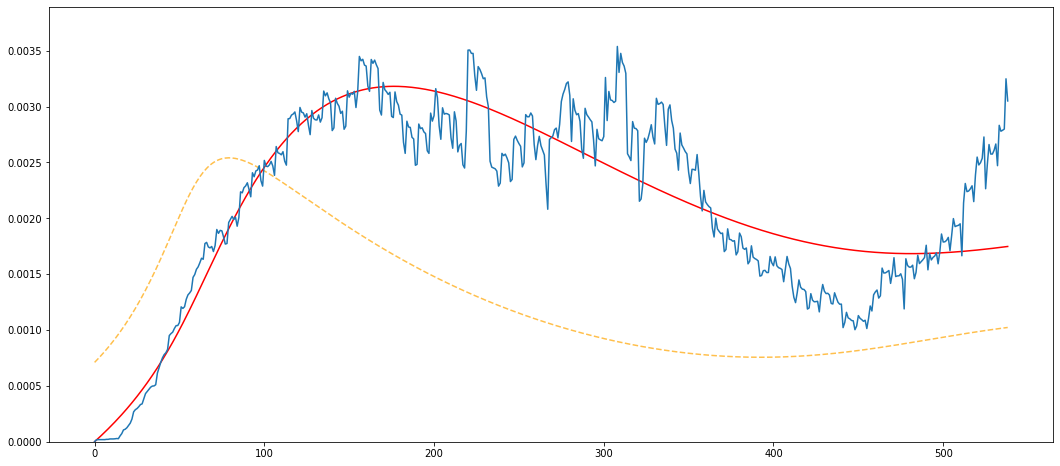

In [96]:
dates, I, R, D, V = owid.LoadCountryNormal("Mexico")
consts = [len(I), I[0], max(I), 0]

mexicoParams = getParams(I, consts, randomIterCount=500, method = "Nelder-Mead")

fig,ax = graphParams(mexicoParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Israel

0 New best error:  4.808092448875152e-05
1 New best error:  4.471130520037144e-05


<ipython-input-140-4672601f8881>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


20 New best error:  4.246936846026376e-05
23 New best error:  3.8151362817117734e-05
37 New best error:  3.732229987506845e-05
62 New best error:  3.722047863593755e-05


(0.0, 0.03125797446355865)

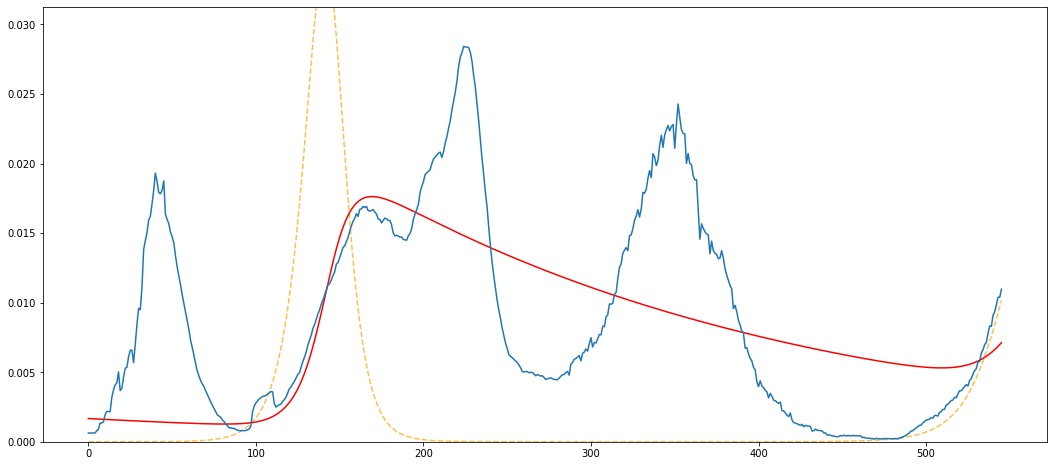

In [161]:
dates, I, R, D, V = owid.LoadCountryNormal("Israel")
consts = [len(I), I[0], max(I), 0]

israelParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(israelParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Russia

0 New best error:  4.746105656984379e-07
1 New best error:  4.5846601468188793e-07


<ipython-input-87-da76d6452b2c>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


7 New best error:  4.455490478509714e-07
29 New best error:  4.282428033876753e-07
45 New best error:  4.2699394339578334e-07


(0.0, 0.0048426861472413325)

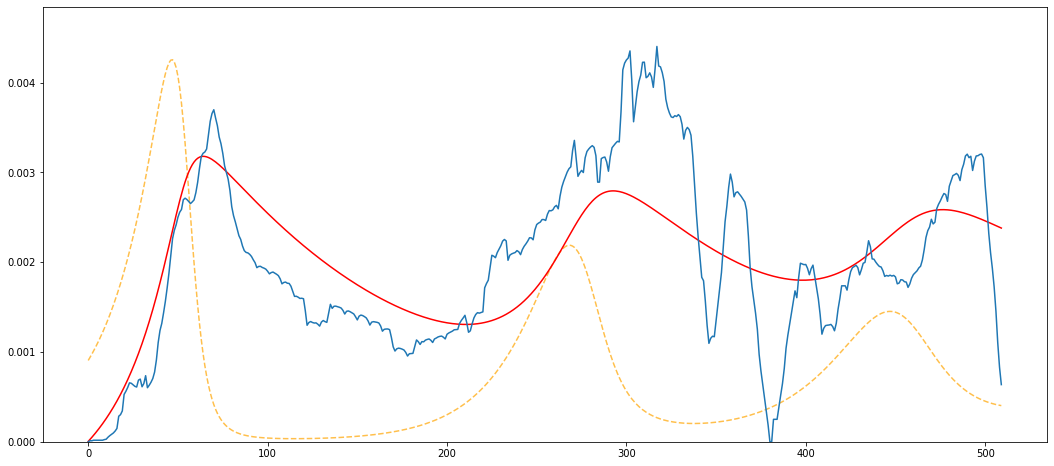

In [98]:
dates, I, R, D, V = owid.LoadCountryNormal("Russia")
consts = [len(I), I[0], max(I), 0]

russiaParams = getParams(I, consts, randomIterCount=500, method = "Nelder-Mead")

fig,ax = graphParams(russiaParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## South Africa

0 New best error:  2.4580172094581873e-06
1 New best error:  1.7070179120334594e-06


<ipython-input-87-da76d6452b2c>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


2 New best error:  1.426961244727865e-06
5 New best error:  1.4012814866493022e-06
182 New best error:  1.3993047255754494e-06
430 New best error:  1.3898448533664222e-06


(0.0, 0.007428818327542211)

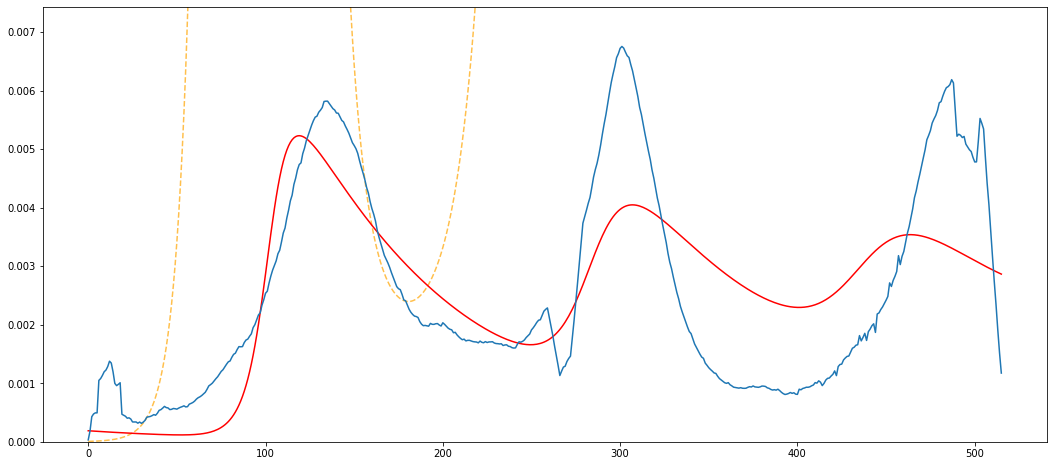

In [99]:
dates, I, R, D, V = owid.LoadCountryNormal("South Africa")
consts = [len(I), I[0], max(I), 0]

southAfricaParams = getParams(I, consts, randomIterCount=500, method = "Nelder-Mead")

fig,ax = graphParams(southAfricaParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Australia

0 New best error:  7.676790574960165e-08
1 New best error:  7.672059243908406e-08


<ipython-input-110-970be1962c01>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


5 New best error:  7.483065145933323e-08
10 New best error:  7.260894537930667e-08
12 New best error:  7.258776824319158e-08
14 New best error:  7.20797881113653e-08


<ipython-input-110-970be1962c01>:131: RuntimeWarning: overflow encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


15 New best error:  6.764002029752295e-08
41 New best error:  6.741727996904616e-08
72 New best error:  6.624726694168029e-08


<ipython-input-110-970be1962c01>:147: RuntimeWarning: overflow encountered in double_scalars
  error = error + ((y[t] - x[t])**2)*wDecay**(len(y)-t+1) #squared error


85 New best error:  6.519746849947672e-08
162 New best error:  6.435991050997387e-08


<ipython-input-110-970be1962c01>:134: RuntimeWarning: overflow encountered in double_scalars
  A[t+1] = diffA + A[t]


217 New best error:  6.377462501189613e-08
240 New best error:  6.170527258761511e-08
352 New best error:  6.164008086259089e-08


(0.0, 0.0011931940762533828)

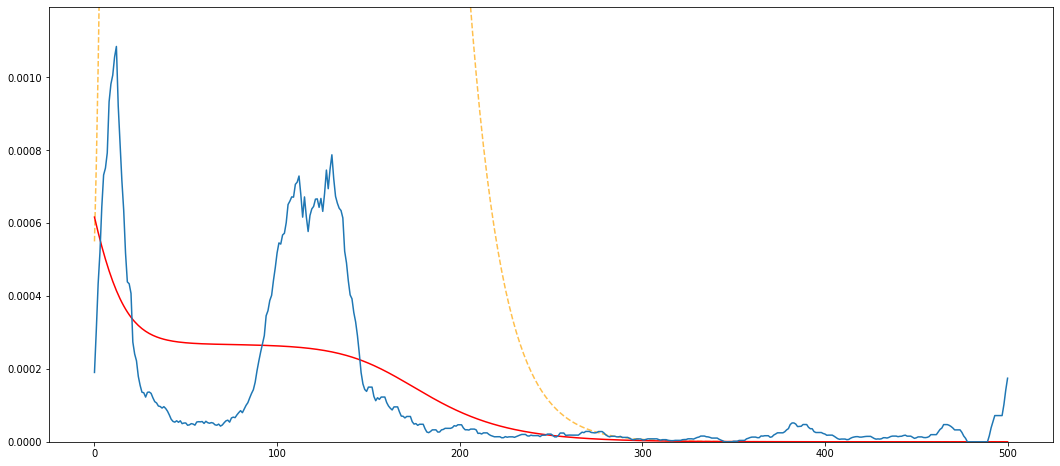

In [135]:
dates, I, R, D, V = owid.LoadCountryNormal("Australia")
consts = [len(I), I[0], max(I), 0]

auParams = getParams(I, consts, randomIterCount=500, wDecay=(3**(1/len(I))), method = "Nelder-Mead")

fig,ax = graphParams(auParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Turkey

(0.0, 0.013013823178018547)

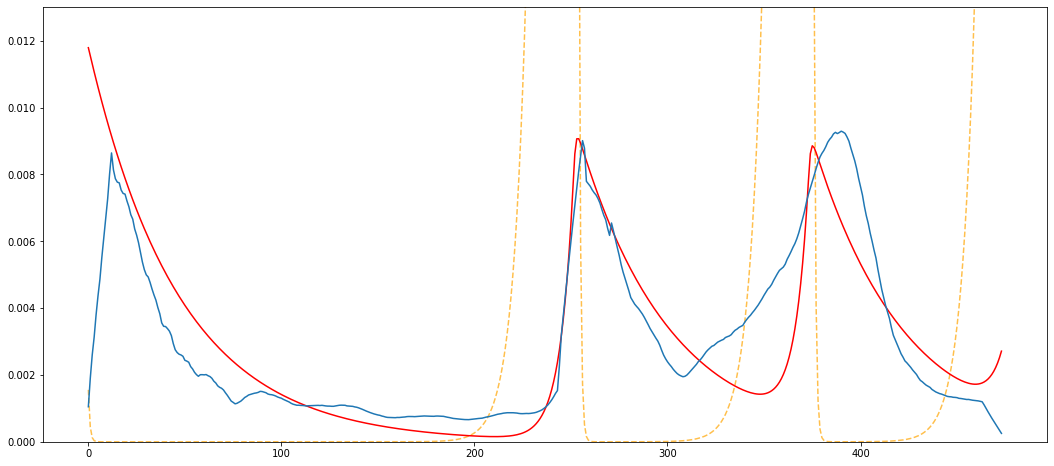

In [120]:
dates, I, R, D, V = owid.LoadCountryNormal("Turkey")

dates = dates[10:]
I = I[10:]
R = R[10:]
D = D[10:]
V = V[10:]

consts = [len(I), I[0], max(I), 0]

turkeyParams = getParams(I, consts, randomIterCount=500, wDecay=(.75**(1/len(I))), method = "Nelder-Mead")

fig,ax = graphParams(turkeyParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.4])

In [162]:
import csv


outputFile = open('..\\Data\\AIRD fits\\fits.csv', 'w')
writer = csv.writer(outputFile)


row = italyParams.tolist()
row.insert(0, "Italy")
writer.writerow(row)

row = usParams.tolist()
row.insert(0, "United States")
writer.writerow(row)

row = ukParams.tolist()
row.insert(0, "United Kingdom")
writer.writerow(row)

row = canadaParams.tolist()
row.insert(0, "Canada")
writer.writerow(row)

row = mexicoParams.tolist()
row.insert(0, "Mexico")
writer.writerow(row)

row = israelParams.tolist()
row.insert(0, "Israel")
writer.writerow(row)

row = russiaParams.tolist()
row.insert(0, "Russia")
writer.writerow(row)

row = southAfricaParams.tolist()
row.insert(0, "South Africa")
writer.writerow(row)

row = auParams.tolist()
row.insert(0, "Australia")
writer.writerow(row)

row = turkeyParams.tolist()
row.insert(0, "turkey")
writer.writerow(row)

outputFile.close()